# Advection diffusion problems
This notebook contains the setup of a flow problem, followed by advection-diffusion problem, where the advective field is derived from the flow. Topics covered include:

* Set up problems with multiple variables, and variables with multiple discretization terms
* Define parameters for transport problems
* Advanced used of the global assembler

The geometry and flow problem are the same as used in MixedDimensionalFlow.ipynb, and the source code is to a large degree copied from there. The discussion below also makes several references to the earlier notebook.


In [1]:
# The standard imports
import numpy as np
from scipy.sparse.linalg import spsolve
from IPython.display import Image

import porepy as pp

c:\users\keile\dropbox\workspace\python\ppdir\src\porepy\grids\partition.py:19: UserWarning: Could not import pymetis. Some functions will not work as    intended
  intended"


## Set up grid and flow problem
The setup is identical to that of the flow problem. 

In [2]:
# Generate the fracture network. This time encapsulate the code in a function
def generate_grid():
    # Define start and endpoints of the fractures.  
    pts = np.array([[0.3, 0.7, 0.8, 0.2],
                    [0.2, 0.8, 0.2, 0.8]])
    # Connection between the points (that is, the fractures) are specified as a 2 x num_frac array
    connections = np.array([[0, 2],
                            [1, 3]])
    # Set the domain to the unit square, specified as a dictionary
    domain = {'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}

    # Define a 2d fracture network 
    network_2d = pp.FractureNetwork2d(pts, connections, domain)

    target_h_bound = 0.3
    target_h_fracture = 0.05

    # The mesh size parameters must be packaged inside a dictionary
    mesh_args = {'mesh_size_bound': target_h_bound, 'mesh_size_frac': target_h_fracture}
    
    # Construct the mesh to obtain a mixed-dimensional PorePy mesh
    gb = network_2d.mesh(mesh_args)
    return gb

In [3]:
# Setup for flow problem, in a function.
def set_parameters_flow(gb, flow_keyword):
    # Maximum dimension of grids represented in the grid bucket
    max_dim = gb.dim_max()

    # Loop over all grids in the GridBucket. 
    # The loop will return a grid, and a dictionary used to store various data
    for g, d in gb:

        # Permeability assignment
        # Differentiate between the rock matrix and the fractures.
        if g.dim == max_dim:
            kxx = np.ones(g.num_cells)
        else:  # g.dim == 1 or 0; note however that the permeability is not used in 0d domains
            kxx = 0.1 * np.ones(g.num_cells)

        perm = pp.SecondOrderTensor(gb.dim_max(), kxx)

        # Create a dictionary to override the default parameters.
        # NB: The permeability is associated wiht the keyword second_order_tensor.
        specified_parameters = {'second_order_tensor': perm}

        # Add boundary conditions for 2d problems
        if g.dim == max_dim:
            # Dirichlet conditions on top and bottom
            # Note that the y-coordinates of the face centers are stored in the 
            # second row (0-offset) of g.face_centers
            top = np.where(np.abs(g.face_centers[1] - 1) < 1e-5)[0]
            bottom = np.where(np.abs(g.face_centers[1]) < 1e-5)[0]

            # On the left and right boundaries, we set homogeneous Neumann conditions
            # Neumann conditions are set by default, so there is no need to do anything

            # Define BoundaryCondition object
            bc_faces = np.hstack((top, bottom))
            bc_type = bc_faces.size * ['dir']
            bc = pp.BoundaryCondition(g, faces=bc_faces, cond=bc_type)

            # Register the assigned value
            specified_parameters['bc'] = bc

            # Alse set the values - specified as vector of size g.num_faces
            bc_values = np.zeros(g.num_faces)
            bc_values[top] = 0
            bc_values[bottom] = 1
            specified_parameters['bc_values'] = bc_values

        # On 1d and 0d problems we set no boundary condition - in effect assigning Neumann conditions

        # Assign the values to the data dictionary d.
        # By using the method initialize_default_data, various other fields are also
        # added, see 
        pp.initialize_default_data(g, d, 'flow', specified_parameters, flow_keyword)


    # Next loop over the edges (interfaces) in the         
    for e, d in gb.edges():
        # On edges in the GridBucket, there is currently no methods for default initialization.

        # Set the normal diffusivity parameter (the permeability-like transfer coefficient)
        data = {"normal_diffusivity": 2e1}
        # Add parameters: We again use keywords to identify sets of parameters.

        mg = d["mortar_grid"]
        pp.initialize_data(mg, d, flow_param_key, data)

## Parameters for the transport problem
The setup below heavily utilizes the default parameters defined for transport problems. Boundary conditions are modified, though.

In [4]:
def set_parameters_transport(gb, parameter_keyword):
    # Maximum dimension of grids represented in the grid bucket
    max_dim = gb.dim_max()

    # Loop over all grids in the GridBucket. 
    # The loop will return a grid, and a dictionary used to store various data
    for g, d in gb:

        # Conductivity tensor assignment. Use the same for rock and fractures
        kxx = np.ones(g.num_cells)

        conductivity = pp.SecondOrderTensor(gb.dim_max(), kxx)

        # Create a dictionary to override the default parameters.
        specified_parameters = {'second_order_tensor': conductivity}

        # Add boundary conditions for 2d problems
        if g.dim == max_dim:
            # Dirichlet conditions on top and bottom, isolating at the boundaries
            # Note that the y-coordinates of the face centers are stored in the 
            # second row (0-offset) of g.face_centers
            top = np.where(np.abs(g.face_centers[1] - 1) < 1e-5)[0]
            bottom = np.where(np.abs(g.face_centers[1]) < 1e-5)[0]

            # On the left and right boundaries, we set homogeneous Neumann conditions
            # Neumann conditions are set by default, so there is no need to do anything

            # Define BoundaryCondition object
            bc_faces = np.hstack((top, bottom))
            bc_type = bc_faces.size * ['dir']
            bc = pp.BoundaryCondition(g, faces=bc_faces, cond=bc_type)

            # Register the assigned value
            specified_parameters['bc'] = bc

            # Alse set the values - specified as vector of size g.num_faces
            bc_values = np.zeros(g.num_faces)
            bc_values[top] = 0
            bc_values[bottom] = 1
            specified_parameters['bc_values'] = bc_values

        # On 1d and 0d problems we set no boundary condition - in effect assigning Neumann conditions

        # Assign the values to the data dictionary d.
        # By using the method initialize_default_data, various other fields are also
        # added, see 
        pp.initialize_default_data(g, d, 'transport', specified_parameters, parameter_keyword)


    # Next loop over the edges (interfaces) in the         
    for e, d in gb.edges():
        # On edges in the GridBucket, there is currently no methods for default initialization.

        # Set the normal diffusivity parameter (the permeability-like transfer coefficient)
        data = {"normal_diffusivity": 2e1}
        # Add parameters: We again use keywords to identify sets of parameters.

        # 
        mg = d["mortar_grid"]
        pp.initialize_data(mg, d, parameter_keyword, data)    
    
    

# Model for transport
The tracer variable $c_i$ in subdomain $\Omega_i$ is governed by the equation 

$$ \frac{\partial c_i}{\partial t} +  \nabla\cdot (c_i\mathbf{u_i}) - \nabla\cdot(D_i\nabla c_i) = f_i - \sum_{j \in \hat{S}_i} \Big( \Xi_j^i\lambda_j^{adv} + \Xi_j^i\lambda_j^{diff}  \Big)$$

Here, $\mathbf{u}$ is the Darcy velocity calculated from the flow solve, and the term $\nabla\cdot (c_i \mathbf{u_i})$ represents advective fluxes. The diffusion tensor is denoted $D_i$, with the term $\nabla\cdot(D_i\nabla c_i)$ representing tracer diffusion. Source terms are given by $f_i$, and the sum on the right hand side represents projection of advective ($\lambda_j^{adv}$) and diffusive ($\lambda_j^{diff}$) fluxes.
For simplicity, we have set the porosity to unity.

The diffusive interface flux is computed analogous to the Darcy problem, the model reads
$$ \lambda_j^{diff} = D_j (\Pi_h^j tr c_h - \Pi_l^j c_l)$$
Recall that for an interface $\Gamma_j$, variables on the higher- and lower-dimensional neighboring subdomains are represented by subscripts $h$ and $l$, respectively.

Advective fluxes over an interface are set according to the upstream direction of the interface Darcy velocity $\lambda_j^{darcy}$. To avoid a technical explanation, we assume that the grids are matching, in which case we define 
$$ \lambda_j^{adv}(c_h, c_l; \lambda_j^{darcy}) = 
\begin{cases} 
c_h, \qquad \lambda_j^{darcy} \geq 0\\
c_l, \qquad \lambda_j^{darcy} < 0\\
\end{cases}
$$
where we have assumed that the Darcy flux is positive if directed from the higher to the lower-dimensional subdomain, as is the definition in PorePy.

# Define discrete variables and discretizations
Variable and discretization assignment becomes more interesting compared to the pure flow problem: The flow discretization is identical to that presented before, and serves as a reference. For the tracer term, we need to introduce three discretizations on the subdomains (accumulation, advection and diffusion), and two mortar variables (advection and diffusion). 

The code below will likely apear to be overly complex, considering that we only want to solve an advection-diffusion equation. In part, matters could have been simplified if PorePy had implemented ready-made modules for standard problems (and this may be reintroduced in the future). Still, most of the definitions are needed to ensure that the framework is applicable to general problems, combinations of discretizations etc. At the end of the day, an advection-diffusion equation contains quite a few number of terms when written out.

In [5]:
def set_discretization(gb, parameter_flow, parameter_transport):
    # The flow discretization is Mpfa for all subdomains
    flow_discretization = pp.Mpfa(keyword=parameter_flow)

    
    # Next discretization objects for the tracer variable
    # For advection and accumulation terms, there is a single option available in PorePy
    advection_discretization = pp.Upwind(keyword=parameter_transport)
    accumulation_discretization = pp.MassMatrix(keyword=parameter_transport)
    
    # The diffusion term in the transport also uses Mpfa. Since the keywords
    # for the two mpfa methods are different, they will access different parameter sets
    diffusion_discretization = pp.Mpfa(keyword=parameter_transport)

    # Set names for the variables
    flow_variable = 'pressure'
    transport_variable = 'tracer'

    # Identifier of the discretization operator for each term.
    flow_operator_key = 'diffusion'
    
    advection_operator_key = 'advection'
    accumulation_operator_key = 'accum'
    diffusion_operator_key = 'diffusion_tracer'
    
    # Next, define quantities on the edges
    # Discretization for the flow problem. 
    edge_discretization_flow = pp.RobinCoupling(parameter_flow,
                                                flow_discretization,
                                                flow_discretization)
    # Variable name for the interface variable
    edge_variable_flow = 'darcy_flux'
    # ... and we need a name for the discretization opertaor for each coupling term
    coupling_operator_key_flow = 'darcy_flux'

    # For the tracer transport, use both an advection and a diffusion term
    # First diffusion - this is much the same as for flow
    edge_discretization_diffusion = pp.RobinCoupling(parameter_transport,
                                                     diffusion_discretization,
                                                     diffusion_discretization)
    # Variable name for the interface variable
    edge_variable_diffusion = 'edge_diffusion'
    # ... and we need a name for the discretization opertaor for each coupling term
    coupling_operator_key_diffusion = 'interface_diffusion'
    
    # Next advection. The __init__ method here is slightly different
    edge_discretization_advection = pp.UpwindCoupling(parameter_transport)
    # Variable name for the interface variable
    edge_variable_advection = 'edge_advection'
    # ... and we need a name for the discretization opertaor for each coupling term
    coupling_operator_key_advection = 'interface_advection'
    
    # Note: There is no accumulation term on the edges

    # Loop over all subdomains in the GridBucket, assign parameters
    # Note that the data is stored in sub-dictionaries
    for g, d in gb:
        # Assign primary variables on this grid, compatible with the designated discretization scheme
        # In this case, both discrete variables are cell centered
        d[pp.PRIMARY_VARIABLES] = {flow_variable: {"cells": 1},
                                   transport_variable: {"cells": 1}}

        # Assign discretization operator for the variables.
        # Flow is as before, while transport has three terms. 
        d[pp.DISCRETIZATION] = {flow_variable: {flow_operator_key: flow_discretization},
                                transport_variable: {advection_operator_key: advection_discretization,
                                                     diffusion_operator_key: diffusion_discretization,
                                                     accumulation_operator_key: accumulation_discretization}
                               }    

    # Next, loop over the edges
    for e, d in gb.edges():
        # Get the grids of the neighboring subdomains
        # The first will always be the lower-dimensional
        g1, g2 = gb.nodes_of_edge(e)
        # The interface variable has one degree of freedom per cell in the mortar grid
        # This is essentially a DG(0) discretization
        d[pp.PRIMARY_VARIABLES] = {edge_variable_flow: {"cells": 1},
                                   edge_variable_advection : {"cells": 1},
                                   edge_variable_diffusion: {"cells": 1}
                                  }

        # The coupling discretization links an edge discretization with variables
        # and discretization operators on each neighboring grid.
        # The code below is copy-paste-modify from the flow problem.
        d[pp.COUPLING_DISCRETIZATION] = {
            coupling_operator_key_flow: {
                g1: (flow_variable, flow_operator_key),
                g2: (flow_variable, flow_operator_key),
                e: (edge_variable_flow, edge_discretization_flow),
            },
            coupling_operator_key_advection: {
                g1: (transport_variable, advection_operator_key),
                g2: (transport_variable, advection_operator_key),
                e: (edge_variable_advection, edge_discretization_advection),
            },
            coupling_operator_key_diffusion: {
                g1: (transport_variable, diffusion_operator_key),
                g2: (transport_variable, diffusion_operator_key),
                e: (edge_variable_diffusion, edge_discretization_diffusion),
            }            
        }    


# Set up and solve the problem
We are finally ready to simulate. The strategy is, first to solve the pressure equation, then calculate the corresponding flux field and make this available to the transport solver. Next, we do time stepping for the transport problem.

We first define a grid, and set parameters and discretization objcets for all terms

In [6]:
gb = generate_grid()

flow_param_key = 'flow'
transport_param_key = 'transport'
set_parameters_flow(gb, flow_param_key)
set_parameters_transport(gb, transport_param_key)
set_discretization(gb, flow_param_key, transport_param_key)

Next, we need an Assembler object to discretize and set up the problem. The Assembler operates on a set of variables, fixed during initialization. By default, the Assembler will consider all variables defined on the subdomains and interfaces. As our aim is to solve flow and transport separately, we define two assemblers, one for each combination of variables.

As a general comment, in the following cells there are quite a few instances of hard coded variable and term names. It would have been better to define these as variables.

In [7]:
assembler_flow = pp.Assembler(gb, active_variables=['pressure', 'darcy_flux'])

assembler_transport = pp.Assembler(gb, active_variables=['tracer', 'edge_advection', 'edge_diffusion'])

Now we can solve the flow problem, just as in the single phase problem.

In [8]:
# First solve flow problem
assembler_flow.discretize()
A_flow, b_flow = assembler_flow.assemble_matrix_rhs()
pressure = spsolve(A_flow, b_flow)
assembler_flow.distribute_variable(pressure)

Next, derive the flux field and make this available for the transport solver. Note that we specify the name of the Darcy mortar flux, and store the value as a parameter for the transport solver

In [9]:
pp.fvutils.compute_darcy_flux(gb, lam_name='darcy_flux', keyword_store=transport_param_key)

Also export the pressure solution

In [10]:
exporter_pressure = pp.Exporter(gb, name='flow', folder='advection_diffusion')
exporter_pressure.write_vtk('pressure')

In [11]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


Next we can discretize and solve the transport problem. We should not do straightforward assembly though, since the accumulation term must be modified to incorporate the time step size. This could of course have been added as a parameter to the accumulation term discretization, but we rather illustrate the usage here. Similarly, functionality to derive time stepping discretization from stationary terms is on its way into PorePy, for future use.

Below, the assembler returns matrices without adding them:

In [12]:
assembler_transport.discretize()

matrices, rhs = assembler_transport.assemble_matrix_rhs(add_matrices=False)

The variables matrices and rhs are now dictionaries with one item per term per variable. The terms can be identified by their operator keywords, together with the variable they are associated with. 

In [13]:
print(matrices.keys())

dict_keys(['accum_tracer', 'diffusion_tracer_tracer', 'interface_diffusion_edge_diffusion_tracer_tracer', 'advection_tracer', 'interface_advection_edge_advection_tracer_tracer'])


To form the system matrix, we first need to set the time step, as this will determine the scaling of the accumulation term

In [14]:
# Set target time and time step. 
dt = 0.1
time = 0
end_time = 3

In [15]:
# Now we can build the system matrix, including the scaling 
# Again, it would have been useful to represent keywords as strings.
A_transport = (matrices['accum_tracer'] / dt 
             + matrices['advection_tracer'] 
             + matrices['diffusion_tracer_tracer'] 
             + matrices['interface_advection_edge_advection_tracer_tracer']  
             + matrices['interface_diffusion_edge_diffusion_tracer_tracer']
              )

num_dof_transport = A_transport.shape[1]

b_transport = np.zeros(num_dof_transport)
for key, vec in rhs.items():
    b_transport += vec

Set a new exporter for the transport problem to avoid confusion with the flow discretization. Also make a list of time steps, we will need this to visualize the time evolution of the tracer propagation.

In [16]:
export_transport = pp.Exporter(gb, name='tracer', folder='advection_diffusion')

time_steps = []

Define a solution vector, distribute it in the GridBucket, and export the initial state.

In [17]:
# Solution vector
tracer = np.zeros(num_dof_transport)

assembler_transport.distribute_variable(tracer)
export_transport.write_vtk('tracer', time_step=time)
time_steps.append(time)

Finally, the time stepping method. We use a backward Euler method.

In [18]:
while time < end_time - 1e-10:
    # Update rhs with values form previous time step
    rhs = b_transport + matrices['accum_tracer'] / dt * tracer

    # Solve linear system
    tracer = spsolve(A_transport, rhs)

    # Increase time
    time += dt
    time_steps.append(time)

    # Distribute and export
    assembler_transport.distribute_variable(tracer)
    export_transport.write_vtk('tracer', time_step=time)
    
# Export the time history as a separate file. This will produce a file 'tracer.pvd', which should be used for visualization
time_steps = np.asarray(time_steps)
export_transport.write_pvd(time_steps)    

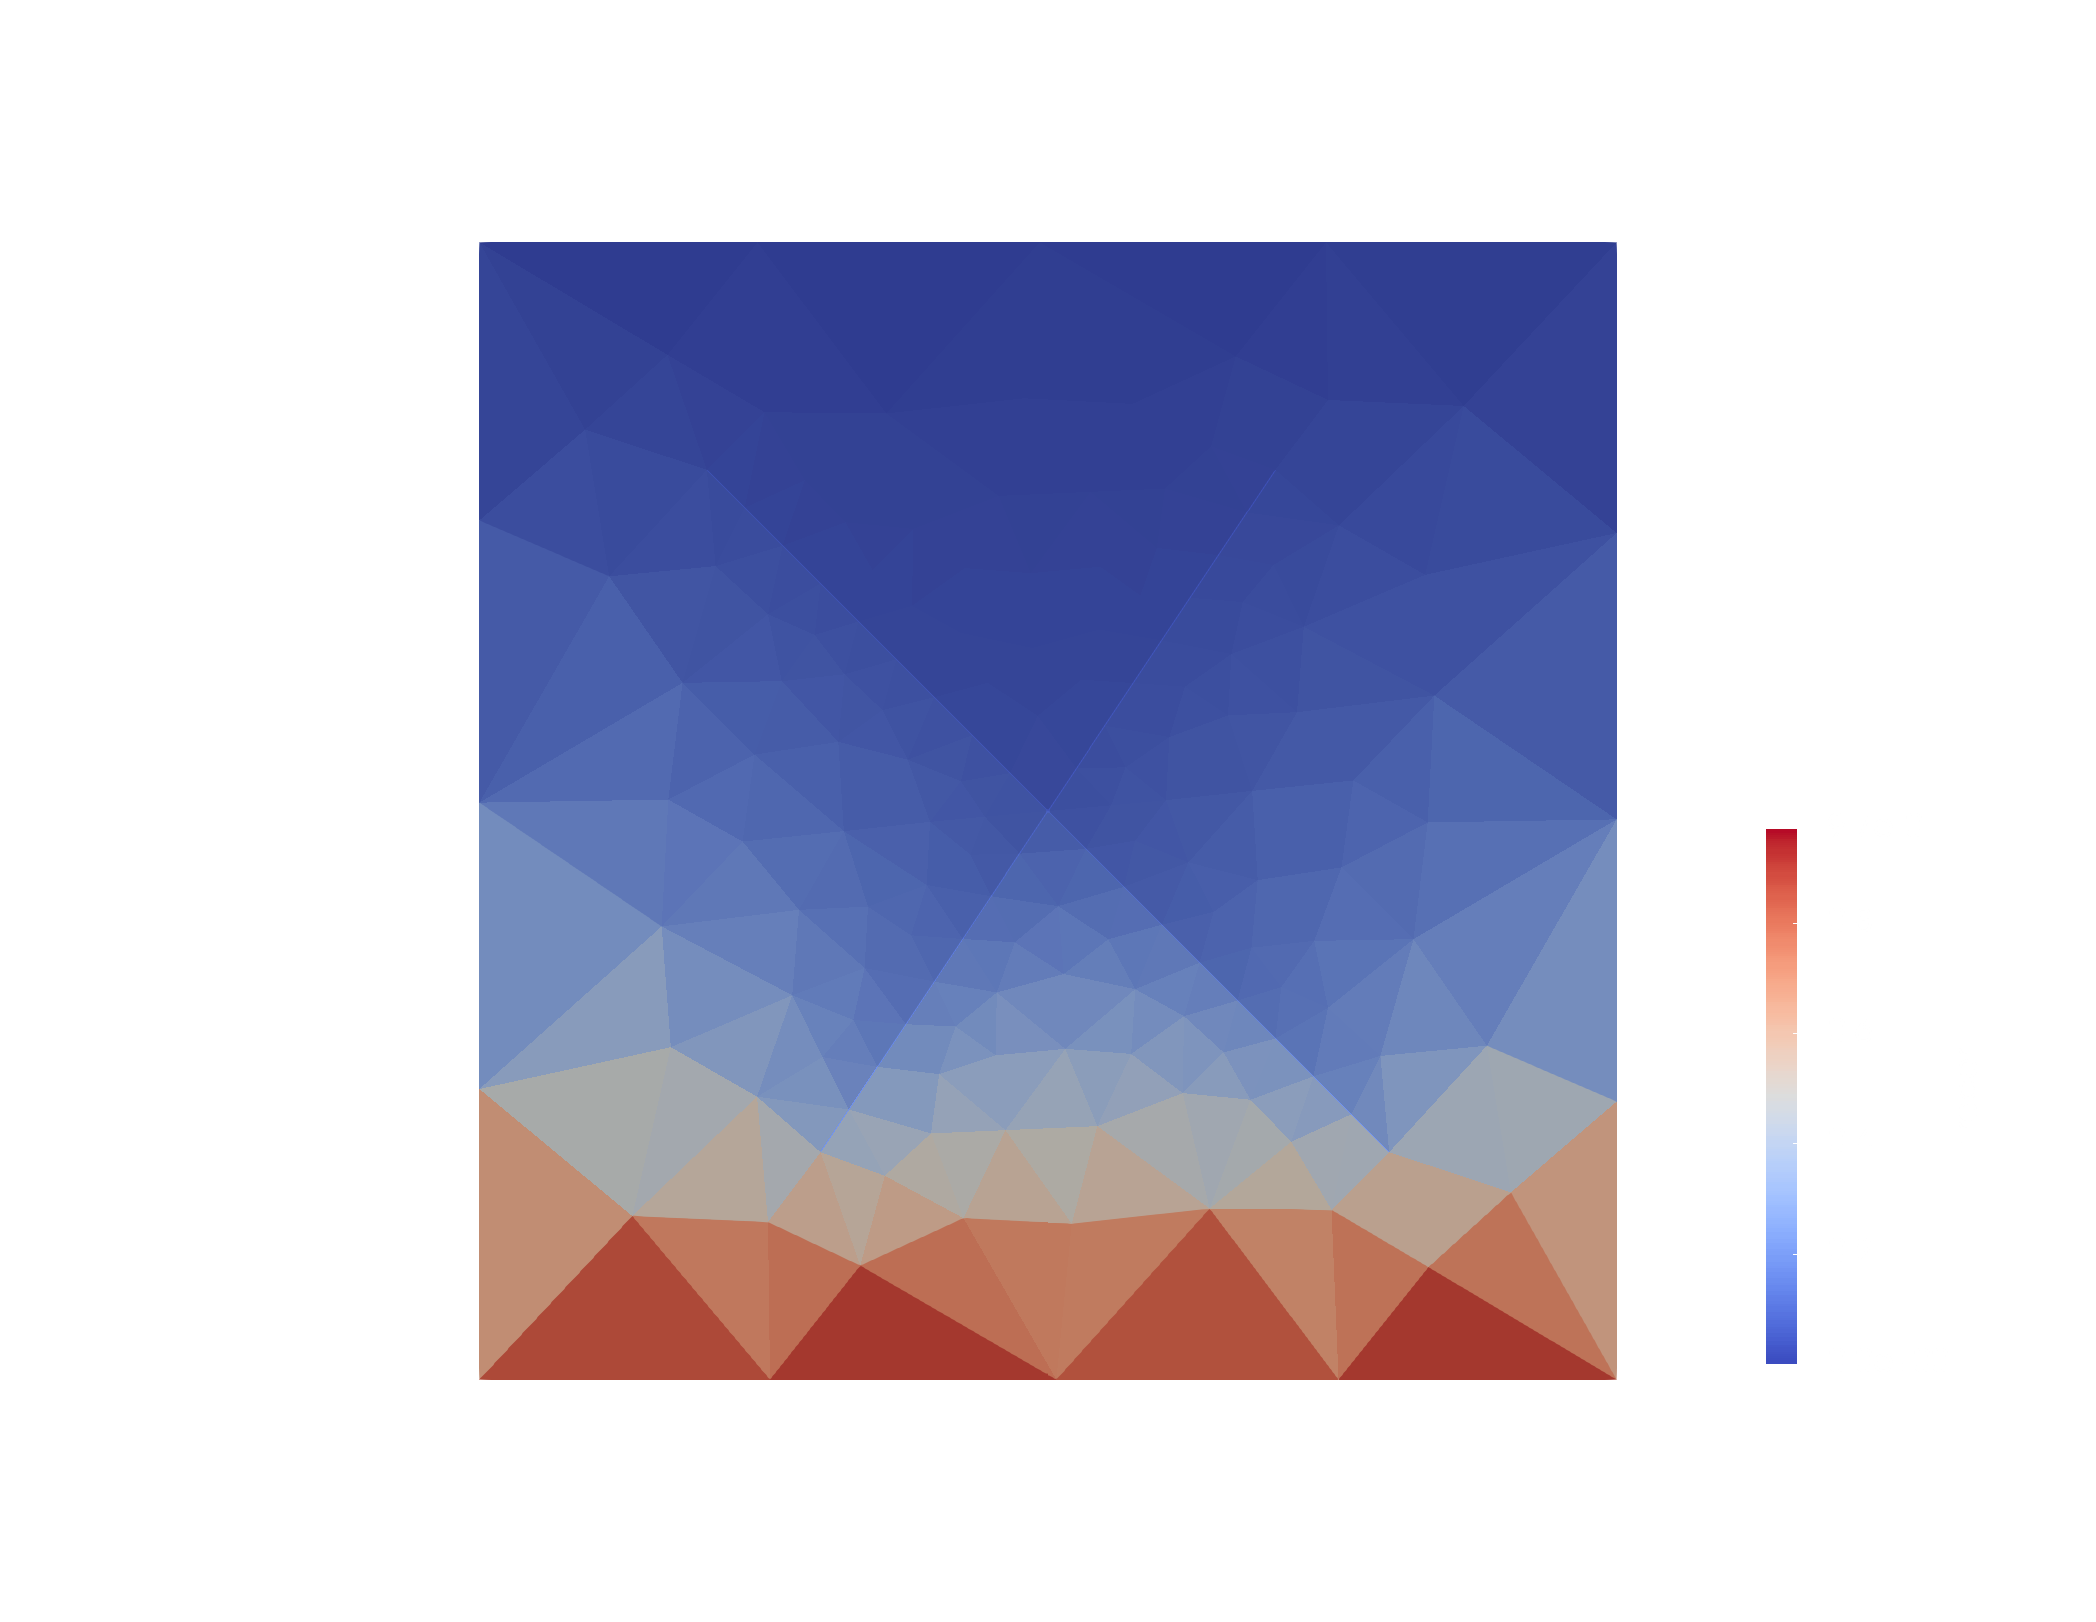

In [19]:
Image("img/advection_diffusion_tracer_early.png")

# Exercises